# Stacked Regressions : Top 4% on LeaderBoard

In [1]:
import numpy as np
import pandas as pd 
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns 
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn = ignore_warn # ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm,skew # for some statistics

pd.set_option('display.float_format',lambda x:'{:.3f}'.format(x))  # limiting floats output to 3 decimal points

# from subprocess import check_output 
# print(check_output(['ls','./house_prices_advanced_regression_techniques/train.csv']).decode('utf8'))
# check the files available in the directory



In [2]:
# import training datasets and test datasets
df_train = pd.read_csv('./house_prices_advanced_regression_techniques/train.csv')
df_test = pd.read_csv('./house_prices_advanced_regression_techniques/test.csv')
# print(df_train.columns)

In [3]:
# display the first five row of the train dataset
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# check the format of sample datasets
print("The train data size before dropping Id feature is : {}".format(df_train.shape))
print("The test data size before dropping Id feature is : {}".format(df_test.shape))

# Save the 'Id' column 
train_ID = df_train['Id']
test_ID = df_test['Id']

# Now drop Id column 
df_train.drop('Id',axis=1,inplace=True)
df_test.drop('Id',axis=1,inplace=True)

# check again the data size after dropping the 'Id' Variable
print("\nThe train data size before dropping Id feature is : {}".format(df_train.shape))
print("The test data size before dropping Id feature is : {}".format(df_test.shape))



The train data size before dropping Id feature is : (1460, 81)
The test data size before dropping Id feature is : (1459, 80)

The train data size before dropping Id feature is : (1460, 80)
The test data size before dropping Id feature is : (1459, 79)


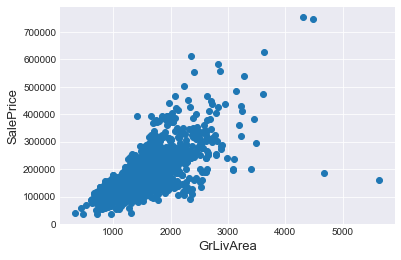

In [5]:
# Outliers, explore the outliers
fig,ax = plt.subplots()
ax.scatter(x=df_train['GrLivArea'],y=df_train['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea',fontsize=13)
plt.show()


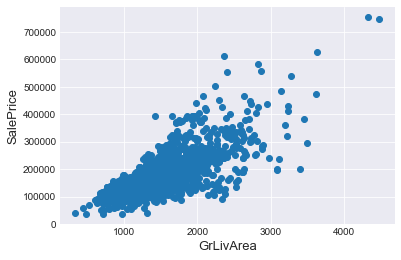

In [6]:
# according the last output we can delete the two outliers appeared on the right
df_train = df_train.drop(df_train[(df_train['SalePrice']<200000) & (df_train['GrLivArea']>4000)].index)
fig,ax = plt.subplots()
ax.scatter(df_train['GrLivArea'],df_train['SalePrice'])
plt.xlabel('GrLivArea',fontsize=13)
plt.ylabel('SalePrice',fontsize=13)
plt.show()
# now the df_train dataset is updated


 mu = 12.02 and sigma = 0.4



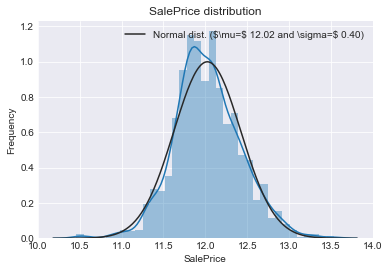

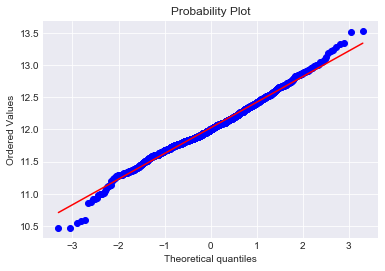

In [7]:
# process the targte variable(use the log preprocess the data)
# 这个部分是画出了正态分布的图，下面的部分是给分布加了注释
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'],fit=norm)
(mu,sigma) = norm.fit(df_train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2}\n'.format(mu,sigma))
# 其中的 miu 和 sigma是正态分布的参数

# 这是对数据进行了对数处理后得出的正态分布
# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and \sigma=$ {:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'],plot=plt)
plt.show()

Features engineering

In [8]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train.SalePrice.values
all_data = pd.concat((df_train,df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'],axis=1,inplace=True)
print("all_data size is:{}".format(all_data.shape))

all_data size is:(2917, 79)


Missing Data

In [9]:
all_data_na = (all_data.isnull().sum()/len(all_data)) * 100
# 每一列里面空值 占 所有值的比例
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
# 上一句的解释：all_data_na是表示每一个特征缺失率的数组(这个数组的shape和输出一致，
# 其中 )
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0,0.5,'Percent missing data by feature')

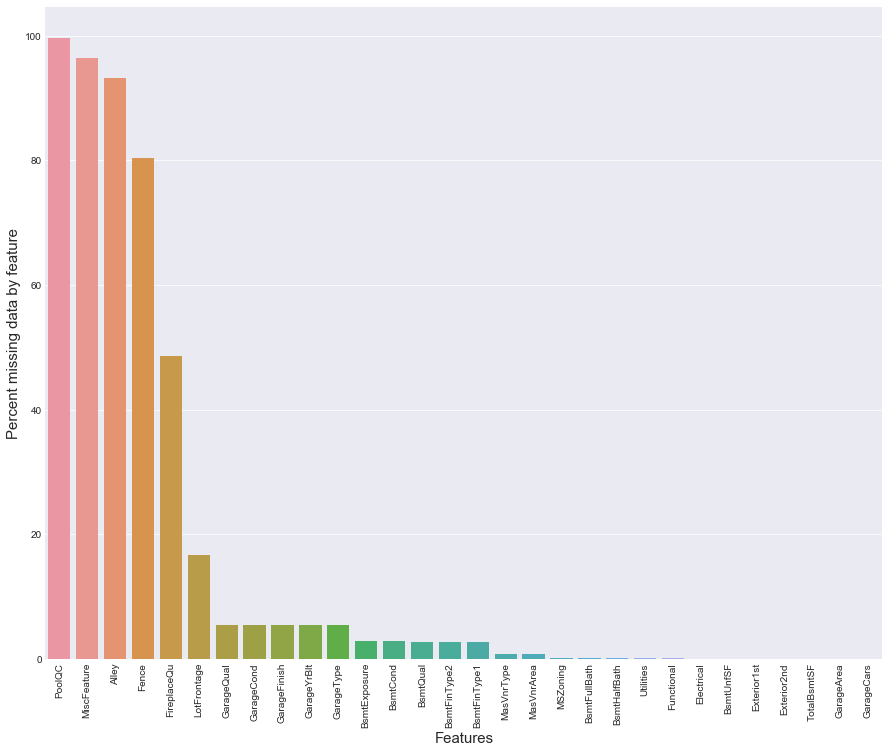

In [10]:
f,ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation = '90')
sns.barplot(x=all_data_na.index,y=all_data_na)
# barplot 柱状图，根据x和y来确定每个坐标值表示什么，进而决定是垂直坐标轴还是平行于坐标轴
plt.xlabel('Features',fontsize=15)
plt.ylabel('Percent missing data by feature',fontsize=15)

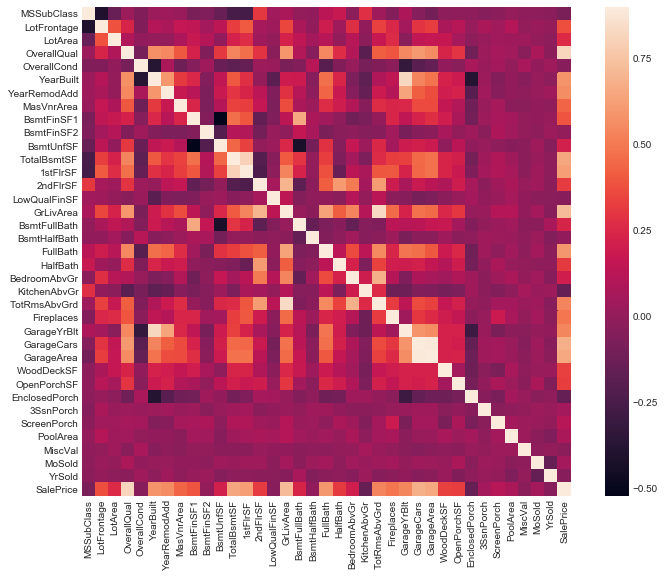

In [11]:
# Correlation map to see how features are correlated with SalePrice 
corrmat = df_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.9,square=True)

Impute missing values
We impute them by proceeding sequentially through features with missing values.

In [12]:
# PoolQC: We will convert values of PoolQC into None, because +99% values are missing
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')
# MiscFeature: data description says NA means 'NO misc feature'
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')
# the reason of the next convertions are same
all_data['Alley'] = all_data['Alley'].fillna('None')
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
# Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
# Functional : data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")
# Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
# KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
# Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
# MSSubClass : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

# LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

# next we should check if there any missing values
all_data_na = (all_data.isnull().sum() / len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
# 把 缺失率为零的数据删除掉
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data.head()

,Missing Ratio


More features engineering
Transforming some numerical variables that are really categorical

In [13]:
# MSSubClass =  The building class
all_data['MSSubClass'] = all_data["MSSubClass"].apply(str)

# Change OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Year and month sold are transformed into categorical features
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


Label Encoding some categorical variables that may contain information in their ordering set

In [15]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu','BsmtQual','BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))
# shape
print("Shape all_data:{}".format(all_data.shape))

Shape all_data:(2917, 78)


Add one more important feature

In [16]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
print(all_data.shape)

(2917, 79)


Skewed features

In [17]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
print('\nSkew in numerical features:\n')
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness.head(10)


Skew in numerical features:



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


Box Cox Transformation of(highly) skewed features(对偏差程度高的数据进行 box cox转换)

In [18]:
# We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x .
# Note that setting  λ=0  is equivalent to log1p used above for the target variable.

skewness = skewness[abs(skewness)>0.75]
print('There are {} skewed numerical features to Box Cox transformation'.format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    # all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat],lam)
    
# all_data[skewed_features] = np.log1p(all_data[skewed_features])
# i以上for循环已经使用 box cox 对数据进行了转化

There are 59 skewed numerical features to Box Cox transformation


Getting dummy categorical features

In [19]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)
# get_dummies就是 使用属性对应的各种可能都变成一种特征

(2917, 220)


In [21]:
# 接下来就可以得到新的转化过后的训练和测试数据
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

# Modeling

In [33]:
# import some library 
from sklearn.linear_model import ElasticNet,Lasso,BayesianRidge,LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


In [41]:
# Define a cross validation strategy
# Validation function
n_folds = 5
# 将数据分成几组
def rmsle_cv(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(df_train.values)
    rmse = np.sqrt(-cross_val_score(model,df_train.values,y_train,scoring='neg_mean_squared_error',cv=kf))
    return(rmse)
# 返回值是每一组的偏差值

In [44]:
# Base models
# LASSO Regression
lasso = make_pipeline(RobustScaler(),Lasso(alpha=0.0005,random_state=1))
# Elastic Net Regression
ENet = make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005,l1_ratio=.9,random_state=3))
# Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6,kernel='polynomial',degree=2,coef0=2.5)
# Gradient Boosting Regression
# With huber loss that makes it robust to outliers
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
# LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
# 上面是训练的模型，下面是对模型的使用，执行顺序：首先建立模型，带入函数，输出值

# Base models scores
score = rmsle_cv(lasso)
print('\nLasso score:{:.4f}({:.4f})\n'.format(score.mean(),score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f}({:.4f})\n".format(score.mean(),score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score:0.1115(0.0074)

ElasticNet score: 0.1116(0.0074)

Kernel Ridge score: 0.1153 (0.0075)

Gradient Boosting score: 0.1177 (0.0080)

Xgboost score: 0.1151 (0.0069)

LGBM score: 0.1154 (0.0071)



Stacking models

In [51]:
# simplest stacking approach: Averaging base model
class AveragingModels(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,models):
        self.models = models
    # we define clones of the original models to fit the data in
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloneed base models
        for model in self.models_:
            model.fit(X,y)
        return self
    # Now we do the predictions for cloned models and average them
    def predict(self,X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions,axis=1)
    # 由此可知cross_val_score在计算返回值的过程中使用到了fit和predict方法


In [52]:
# Averaged base models score,(the included models:ENet,GBoost,KRR and lasso)
averaged_models = AveragingModels(models=(ENet,GBoost,KRR,lasso))
score = rmsle_cv(averaged_models)
print("Averaged bse models score:{:.4f}({:.4f})\n".format(score.mean(),score.std()))


Averaged bse models score:0.1091(0.0075)



In [57]:
# Less simple Stacking: Adding a Meta-model
class StackingAveragedModels(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,base_models,meta_model,n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        # We again fit the data on clones of the original models
        
    def fit(self,X,y):
        self.base_models_ = [list() for x in self.base_models]
        # 上述返回的是由空列表组成的列表
        # 列表值的填充在下面进行
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds,shuffle=True,random_state=156)
            
        # Train cloned base models then create out-of-fold predictions that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0],len(self.base_models)))
        for i,model in enumerate(self.base_models):
            for train_index,holdout_index in kfold.split(X,y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
    # 这就是第二层训练了
        return self
    # Do the predictions of all base models on the test data and use the averaged predictions as 
    # meta-features for the final prediction which is done by the meta-model
    def predict(self,X):
        meta_features = np.column_stack([np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) for base_models in self.base_models_ ])
        # 上一行代码从右至左,由内而外的解析：首先选择 base_models(交叉验证产生的不同的模型),然后使用这里面的模型分别预测数据，然后在以列为单位求平均值，
        # 在求平均值之前的参数矩阵形式为每一行是某一类(即同类模型，不同测试数据)模型的针对相同值的预测，
        # 自己把上述 stack 的过程画一遍就好了，stack 和 list()是相反的过程。
        # 最后的均值 是算的使用相同源数据训练的不同类的分类器的预测结果的均值
        return self.meta_model_.predict(meta_features)

In [58]:
# Stacking Averaged models Score
stacked_averaged_models = StackingAveragedModels(base_models = (ENet,GBoost,KRR),meta_model=lasso)
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score:{:.4f}({:.4f})".format(score.mean(),score.std()))

Stacking Averaged models score:0.1085(0.0074)


Ensembling StackedRegressor,XGBoost and LightGBM

In [59]:
# We add XGBoost and LightGBM to the StackedRegressor defined previously.
# We first define a rmsle evaluation function
def rmsle(y,y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

In [60]:
# Final Training and Prediction
# StackedRegressor
stacked_averaged_models.fit(df_train.values,y_train)
stacked_train_pred = stacked_averaged_models.predict(df_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(df_test.values))
print(rmsle(y_train,stacked_train_pred))

0.0781571937916


In [64]:
# XGBoost
model_xgb.fit(df_train,y_train)
xgb_train_pred = model_xgb.predict(df_train)
xgb_pred = np.expm1(model_xgb.predict(df_test))
print(rmsle(y_train,xgb_train_pred))

0.0787989479925


In [65]:
# LightGBM
model_lgb.fit(df_train,y_train)
lgb_train_pred = model_lgb.predict(df_train)
lgb_pred = np.expm1(model_lgb.predict(df_test.values))
print(rmsle(y_train,lgb_train_pred))

0.0724782372438


In [66]:
# RMSE on the entire Train data when averaging
print("RMSLE score on train data:")
print(rmsle(y_train,stacked_train_pred*0.7 + xgb_train_pred*0.15 + lgb_train_pred * 0.15))



RMSLE score on train data:
0.0753523435715


In [69]:
# Ensemble prediction
ensemble = stacked_pred * 0.7 +xgb_pred * 0.15 + lgb_pred*0.15

In [70]:
# Submission 
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission2.csv',index=False)